     raster_val                                           geometry
0             0  POLYGON ((11448405.453 -1046970.538, 11449405....
1             0  POLYGON ((11449405.453 -1046970.538, 11450405....
2             0  POLYGON ((11450405.453 -1046970.538, 11451405....
3             0  POLYGON ((11451405.453 -1046970.538, 11452405....
4             0  POLYGON ((11452405.453 -1046970.538, 11453405....
..          ...                                                ...
943           0  POLYGON ((11456405.453 -1091970.538, 11457405....
944           0  POLYGON ((11457405.453 -1091970.538, 11458405....
945           0  POLYGON ((11458405.453 -1091970.538, 11459405....
946           0  POLYGON ((11459405.453 -1091970.538, 11460405....
947           0  POLYGON ((11482405.453 -1058970.538, 11485405....

[948 rows x 2 columns]


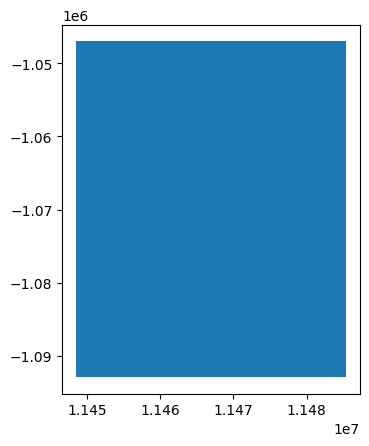

[<POLYGON ((11448405.453 -1046970.538, 11449405.453 -1046970.538, 11449405.45...>, <POLYGON ((11449405.453 -1046970.538, 11450405.453 -1046970.538, 11450405.45...>, <POLYGON ((11450405.453 -1046970.538, 11451405.453 -1046970.538, 11451405.45...>, <POLYGON ((11451405.453 -1046970.538, 11452405.453 -1046970.538, 11452405.45...>, <POLYGON ((11452405.453 -1046970.538, 11453405.453 -1046970.538, 11453405.45...>, <POLYGON ((11453405.453 -1046970.538, 11454405.453 -1046970.538, 11454405.45...>, <POLYGON ((11454405.453 -1046970.538, 11455405.453 -1046970.538, 11455405.45...>, <POLYGON ((11455405.453 -1046970.538, 11456405.453 -1046970.538, 11456405.45...>, <POLYGON ((11456405.453 -1046970.538, 11457405.453 -1046970.538, 11457405.45...>, <POLYGON ((11457405.453 -1046970.538, 11458405.453 -1046970.538, 11458405.45...>, <POLYGON ((11458405.453 -1046970.538, 11459405.453 -1046970.538, 11459405.45...>, <POLYGON ((11459405.453 -1046970.538, 11460405.453 -1046970.538, 11460405.45...>, <POLYGON ((1146

TypeError: 'numpy.ndarray' object is not callable

In [9]:
import rasterio
from rasterio.features import shapes
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from rasterio.mask import mask

with rasterio.open('built_up_denpasar.tif') as src:
    image = src.read(1)  
    mask = (image != src.nodata) & ~np.isnan(image) 

    results = (
        {'properties': {'raster_val': int(v)}, 'geometry': s}
        for i, (s, v) in enumerate(
            shapes(image, mask=mask, transform=src.transform))
        if not np.isnan(v) and v != src.nodata 
    )

    schema = {
        'geometry': 'Polygon',
        'properties': {'raster_val': 'int'},
    }

    with fiona.open('denpasar.shp', 'w', 'ESRI Shapefile', schema) as dst:
        for result in results:
            dst.write(result)

shapefile = gpd.read_file('denpasar.shp')
print(shapefile) 
shapefile.plot()
plt.show()

with rasterio.open('built_up_denpasar.tif') as src:
    shapefile = shapefile.dropna()

    shapes = [geom for geom in shapefile.geometry]

    print(shapes)

    out_image, out_transform = mask(src, shapes, crop=True)

    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    with rasterio.open('masked_denpasar.tif', 'w', **out_meta) as dest:
        dest.write(out_image)

plt.figure()
plt.imshow(out_image[0], cmap='GnBu')
plt.show()